# Generating the Input Joint Distribtution 

The first step to apply an information bottleneck algorithm is to define a proper input distribution $p(x,y)$ which describes the relation between the relevant variable $X$ and the observed random variable $Y$ 

First, we assume an AWGN channel with BPSK transmission.

In [1]:
import numpy as np
from scipy.stats import norm

sigma_n2 = 0.1 # Noise variance
amplitudes = np.array([-1,+1]) # BPSK amplitudes are +1 and -1

p_x = np.array([0.5,0.5]) # uniformly distributed transmit symbols

card_Y = 2000 # choose a fine discretization of the cont. variable Y
card_T = 16   # cardinality of the compression variable
y = np.linspace(norm.ppf(1e-12, loc=amplitudes.min(), scale=np.sqrt(sigma_n2)),
                norm.ppf(1-1e-12, loc=amplitudes.max(), scale=np.sqrt(sigma_n2)), card_Y) # define the eventspace
delta_y = np.abs(y[1] - y[0])

p_y_given_x = np.zeros((y.shape[0],2))
for x_idx, x in enumerate(amplitudes):
    p_y_given_x[:,x_idx] = norm.pdf(y, loc=x, scale=np.sqrt(sigma_n2))*delta_y
    
p_y_and_x = p_y_given_x * p_x
p_y_and_x /= p_y_and_x.sum()


Depicting the corresponding conditional distribution $p(y|x)$ yields:

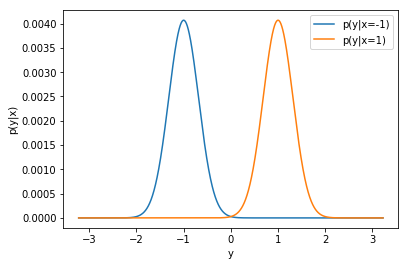

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
for x_idx, x in enumerate(amplitudes):
    plt.plot(y,p_y_given_x[:,x_idx],label="p(y|x="+str(x)+")")
plt.ylabel("p(y|x)")
plt.xlabel("y")
plt.legend()
plt.show()

## Running Information Bottleneck Algorithms

In this section, we will use three exemplary information bottleneck algorithm to show the syntax of the respective algorithms and how to access the lookup table $p(t|y)$ and the cluster meaning $p(x|t)$.

### Sequential Symmetric Information Bottleneck Algorithm [LB18]

In [3]:
from information_bottleneck.information_bottleneck_algorithms.symmetric_sIB import symmetric_sIB

In [4]:
IB_algo = symmetric_sIB(p_x_y_=p_y_and_x,
                        card_T_=card_T,
                        nror_=10)
IB_algo.run_IB_algo()

Run: [######################################################################] 100.0% 10 / 10    

[0.99671077 0.99671077 0.99663618 0.99671077 0.99671077 0.99671077
 0.99671077 0.99671077 0.99671077 0.99671077]


In [5]:
IB_algo.display_MIs()

----- Mutual Information Comp --- 
-----  symmetric sIB  ------ 
MI_XT_s=  0.996710768209693
MI_XY_s=  0.9967563279900288
ratio=  0.999954291957767


### Agglomerative Information Bottleneck Algorithm [Slo02]

In [6]:
from information_bottleneck.information_bottleneck_algorithms.aIB_class import aIB

In [7]:
IB_algo = aIB(p_x_y_=p_y_and_x,
              card_T_=card_T)
IB_algo.run_IB_algo()

In [8]:
IB_algo.display_MIs()

----- Mutual Information Comp --- 
-----  agglomerative IB  ------ 
MI_XT_s=  0.9967042556375114
MI_XY_s=  0.9967563279900288
ratio=  0.999947758192193


### KL-Means Algorithm [K17] 

In [9]:
from information_bottleneck.information_bottleneck_algorithms.KLmeansIB_class import KLmeansIB as KLmeans

In [10]:
IB_algo = KLmeans(p_x_y_=p_y_and_x,
              card_T_=card_T,
              nror=100)
IB_algo.run_IB_algo()

 [Elapsed Time: 0:00:00] |                                  | (ETA:  --:--:--) 

###  OPENCL Device #####
[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL' at 0x2206dbc4c70>]


 [Elapsed Time: 0:00:23] |##################################| (Time:  0:00:23) 


Winner finished in  62.0  iterations.
Average number of iterations to finished: 62.17


In [11]:
IB_algo.display_MIs()

----- Mutual Information Comp --- 
-----  KL means IB  ------ 
MI_XT_s=  0.996709002779566
MI_XY_s=  0.9967563279900288
ratio=  0.9999525207825284


## Reading the Outputs of the Algorithm

In [12]:
# LUT p(t|y)
p_t_given_y = IB_algo.p_t_given_y
LUT = np.argmax(IB_algo.p_t_given_y,axis=1)

# Meaning p(x|t)
p_x_given_t = IB_algo.p_x_given_t

Text(0,0.5,'L(x|t)')

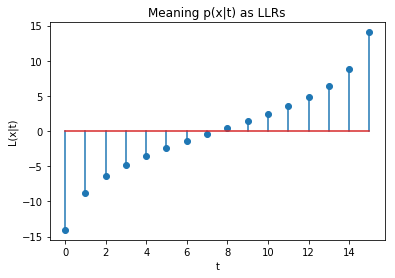

In [13]:
plt.stem(np.arange(card_T),np.log(p_x_given_t[:,1]/p_x_given_t[:,0]))
plt.title("Meaning p(x|t) as LLRs")
plt.xlabel("t")
plt.ylabel("L(x|t)")

## References
- [LB18] J. Lewandowsky and G. Bauch, “Information-Optimum LDPC Decoders Based on the Information Bottleneck Method,” IEEE Access, vol. 6, pp. 4054–4071, 2018.
- [Slo02] N. Slonim, “The Information Bottleneck Theory and Applications,” Hebrew University of Jerusalem, 2002.
- [K17] B. M. Kurkoski, “On the relationship between the KL means algorithm and the information bottleneck method,”in SCC 2017; 11th International ITG Conference on Systems, Communications and Coding, Feb 2017, pp. 1–6.